Consider images from the MNIST dataset, $X_k$, with missing pixels, $k = 1, 2, . . . , K$.
Denote by $\Omega_k$ binary matrices which indicate the missing elements in $X_k$, $w(i, j) = 0$ for the missing elements $x(i, j)$, otherwise $w(i, j) = 1$.

Solve an SVM problem which finds a hyperplane $\{X | tr(W^TX) + b = 0\}$ such that

$$
\begin{align*}
\min_{W,b} \quad & \frac{1}{2}||W||_F^2\\
st. \quad & y_k(tr(W^TX_k) + b) \geq 1, \quad k =1,2,...,K
\end{align*}
$$

where $y_k \in \{-1,1\}$  are labels for $X_k$

Develop and implement an ADMM algorithm to solve the above problem

$$
\begin{align*}
y_k(tr(W^TX_k) + b) - 1 & \geq 0\\
\min(0,y_k(tr(W^TX_k) + b) - 1) & = 0\\
\end{align*}
$$
denote $g_k =y_k(tr(W^TX_k) + b) - 1$
$$
h = \min(0,diag([y_1,...,y_K]^T) [g_1,...,g_K]^T)
$$
rewrite the problem 

$$
\begin{align*}
\min_{W,b} \quad & \frac{1}{2}||W||_F^2\\
st. \quad & h = 0
\end{align*}
$$

$$
\begin{align*}
\mathcal{L} = \frac{1}{2}||W||_F^2 + \frac{\alpha}{2}||h + u||^2_2
\end{align*}
$$
ADMM:
$$
\begin{align*}
g^k_i&=y_i(tr(W^TX_i) + b) - 1\\
h & = \min(0,diag([y_1,...,y_K]^T) [g^k_1,...,g^k_K]^T)\\
W^{k+1} &= \argmin_W\mathcal{L}(W,b^k,u^k)\\
b^{k+1} &= \argmin_b\mathcal{L}(W^k,b,u^k)\\
u^{k+1} &= u^k + h^k\\
\end{align*}
$$

Missing elements:
Lets rewrite $tr(W^TX) = \sum W_{ij}X_{ij}$ to consider only existing elements I substituted $X_{ij} = 0$ where a pixel is missing. We should minimize only such $W_{ij}$ that partisipated in prediction so I substituted $||W||^2_F$ with $||W \circ \Omega_{mean}||^2_F$ where $ \Omega_{mean} = \sum \Omega_k/K$. But it doesnt work well.

In [1]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from numpy.linalg import inv
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score
import cvxpy as cp

cp_type = cp.expressions.variable.Variable

2023-12-17 22:38:21.112593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 22:38:21.112642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 22:38:21.113512: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 22:38:21.119539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 22:38:21.940960: W tensorflow/compiler/tf2

In [2]:
# def generate_missig_indexes(N):
#     cols = np.random.choice(list(range(0, 28)), size=N)
#     rows = np.random.choice(list(range(0, 28)), size=N)
#     return rows, cols


def generate_mask(missing_elements):
    ones = np.ones(28 * 28 - missing_elements)
    zeroes = np.zeros(missing_elements)
    mask = np.hstack([ones, zeroes])
    mask = np.random.permutation(mask)
    mask = mask.reshape((28, 28))
    return mask


def get_img_labels(X, Y, missing_elements, N):
    is_0_8 = (Y == 0) | (Y == 8)
    labels = Y[is_0_8][:N].astype(float)
    images = X[is_0_8][:N].astype(float) / 255

    labels = labels / 4 - 1  ## to make [-1,1] labels

    mask_list = []
    for _ in range(N):
        mask_list.append(generate_mask(missing_elements))
    images = [images[i] * mask_list[i] for i in range(N)]

    return images, labels, mask_list


# def corrupt_img(img, missing_elements):
#     mis_rows, mis_cols = generate_missig_indexes(missing_elements)
#     img[mis_rows, mis_cols] = 0
#     return img

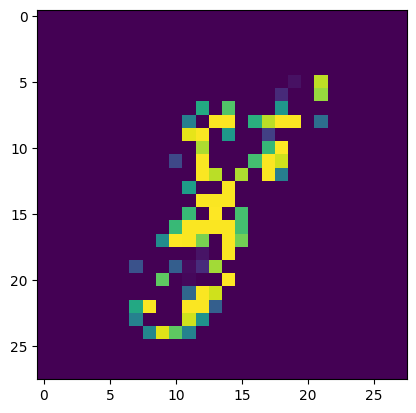

In [3]:
(images_train, labels_train), (img_test, lab_test) = mnist.load_data()
missing_elements = 28 * 28 // 2

N_train = 8000
images_train, labels_train, mask_list_train = get_img_labels(
    images_train, labels_train, missing_elements, N_train
)

N_test = 1000
images_test, labels_test, mask_list_test = get_img_labels(
    img_test, lab_test, missing_elements, N_test
)

plt.imshow(images_train[1])

In [4]:
mask_mult = np.zeros((28, 28))
for mask in mask_list_train:
    mask_mult = mask_mult + mask
Omega = mask_mult / N_train

Here I did the update rules. Need to mention that I used constraints p > 0, because otherwise always violated the DCP rules (with abs, max, exp etc, didnt know what to do and just added that constraint).

In [5]:
class my_solver:
    def __init__(self, X, Y, alpha, N, use_all_W) -> None:
        self.X = X
        self.Y = Y
        self.alpha = alpha
        self.N = N
        self.use_all_W = use_all_W

    def argmin_L(self, W=None, b=None, u=None, p=None):
        constraints = []
        if W is None:
            W = cp.Variable((28, 28))
        elif b is None:
            b = cp.Variable(1)
        elif p is None:
            p = cp.Variable((self.N, 1))
            constraints = [p >= 0]

        g = []
        for k in range(self.N):
            X_k = self.X[k]
            y_k = self.Y[k]

            g_k = y_k * (cp.trace(W.T @ X_k) + b) - 1
            g.append(g_k)
        g = cp.vstack(g)

        if self.use_all_W:
            L = cp.norm(W, "fro") ** 2 + self.alpha * cp.norm(g - p + u, 2) ** 2
        else:
            L = (
                cp.norm(cp.multiply(W, Omega), "fro") ** 2
                + self.alpha * cp.norm(g - p + u, 2) ** 2
            )
        prob = cp.Problem(cp.Minimize(L), constraints)
        prob.solve("SCS")

        if type(W) is cp_type:
            return W.value
        elif type(b) is cp_type:
            return b.value
        elif type(p) is cp_type:
            return p.value

    def update_u(self, W, b, u, p):
        g = []
        for k in range(self.N):
            X_k = self.X[k]
            y_k = self.Y[k]

            g_k = y_k * (np.trace(W.T @ X_k) + b) - 1
            g.append(g_k)
        g = np.vstack(g)
        return u + g - p


def predict(W, X, b):
    return np.trace(W.T @ X) + b

In [6]:
W = np.random.random((28, 28))
b = np.random.random()
u = np.random.random((N_train, 1))
p = np.random.random((N_train, 1))
p = p * p

alpha = 1
solver = my_solver(images_train, labels_train, alpha=alpha, N=N_train, use_all_W=True)

for _ in range(3):
    W = solver.argmin_L(W=None, b=b, u=u, p=p)
    b = solver.argmin_L(W=W, b=None, u=u, p=p)
    p = solver.argmin_L(W=W, b=b, u=u, p=None)
    u = solver.update_u(W=W, b=b, u=u, p=p)


success = []
for k in range(N_train):
    success.append(labels_train[k] * predict(W, images_train[k], b))
result_train = sum(np.vstack(success) > 0) / N_train

success = []
for k in range(N_test):
    success.append(labels_test[k] * predict(W, img_test[k], b))
result_test = sum(np.vstack(success) > 0) / N_test

print(f" accuracy train {result_train} accuracy test {result_test}")

/home/sun/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/sun/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #1 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/sun/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


 accuracy train [0.99] accuracy test [0.534]


• Treat the missing elements in $X_k$ as zeros, and solve the SVM problem (7) again. Compare
performance of the two methods.

use_all_W in code means to use $||W||^2_F$ in L else use $||W \circ \Omega_{mean}||^2_F$ where $ \Omega_{mean} = \sum \Omega_k/K$

In [7]:
W = np.random.random((28, 28))
b = np.random.random()
u = np.random.random((N_train, 1))
p = np.random.random((N_train, 1))
p = p * p

alpha = 1
solver = my_solver(images_train, labels_train, alpha=alpha, N=N_train, use_all_W=False)

for _ in range(3):
    W = solver.argmin_L(W=None, b=b, u=u, p=p)
    b = solver.argmin_L(W=W, b=None, u=u, p=p)
    p = solver.argmin_L(W=W, b=b, u=u, p=None)
    u = solver.update_u(W=W, b=b, u=u, p=p)


success = []
for k in range(N_train):
    success.append(labels_train[k] * predict(W, images_train[k], b))
result_train = sum(np.vstack(success) > 0) / N_train

success = []
for k in range(N_test):
    success.append(labels_test[k] * predict(W, img_test[k], b))
result_test = sum(np.vstack(success) > 0) / N_test

print(f" accuracy train {result_train} accuracy test {result_test}")

 accuracy train [0.990375] accuracy test [0.544]


So you may see the results Num train imgs (8000) test (1000) (the bigger number leads to problems with my laptop).\
Method with substitution of missing pixels with zero \
accuracy train [0.99] accuracy test [0.534]\
My method\
accuracy train [0.990375] accuracy test [0.544] \